<a href="https://colab.research.google.com/github/20EirinAJ/Sato-Lab/blob/Prediction-of-protein-compound-binding/project3_rdkit_new_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# タンパク質・化合物結合予測プログラムの実装

In [ ]:
!pip install optuna

In [ ]:
# ライブラリのインポート
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import optuna
import optuna.integration.lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from sklearn.metrics import f1_score, precision_recall_fscore_support # F1の値
from sklearn import model_selection 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.6 MB/s 


In [ ]:
!curl -Lo tox21_10k_all.sdf.zip https://bit.ly/2T6beHP
!unzip tox21_10k_all.sdf.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   168  100   168    0     0    721      0 --:--:-- --:--:-- --:--:--   721
100 2565k    0 2565k    0     0   400k      0 --:--:--  0:00:06 --:--:--  598k
Archive:  tox21_10k_all.sdf.zip
  inflating: tox21_10k_data_all.sdf  


In [ ]:
from rdkit import Chem

sup = Chem.SDMolSupplier('tox21_10k_data_all.sdf')
train = [mol for mol in sup 
         if mol is not None and 'NR-AR' in mol.GetPropsAsDict()]

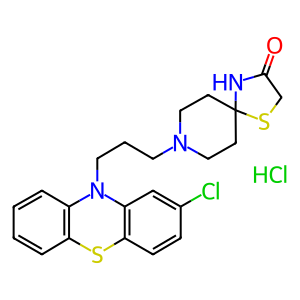

In [ ]:
from rdkit.Chem import Draw

display(Draw.MolToImage(train[400]))

In [ ]:
import numpy as np
from rdkit.Chem import AllChem
from rdkit import DataStructs

X = [ AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in train]
X = [ np.asarray(x) for x in X]
X = np.vstack(X)

y = [m.GetIntProp('NR-AR') for m in train]
y = np.array(y)

print('X:', X.shape, 'y:', y.shape)

X: (9358, 2048) y: (9358,)


# テストと訓練データの分割

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [8978  380]
Labels counts in y_train: [6284  266]
Labels counts in y_test: [2694  114]


# 学習モデルの構築：ここをいじる
アンサンブル法を試してみる。弱分類器を沢山用意して、機械学習の多数決で最終判断を下す。

In [ ]:
seed = 0

kfold = model_selection.KFold(n_splits = 5) 
scores = {}

# パラメータ指定無しのLightGBM
Acc: 0.9750712250712251\
F: 0.6236559139784946

In [ ]:
# モデルの学習
model = lgb.LGBMClassifier() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測クラス (予測クラス(0 or 1)を返す)
y_pred = model.predict(X_test)
# テストデータのクラス予測確率 (各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率] を返す)
y_pred_prob = model.predict_proba(X_test)

# パラメータを指定したLightGBMは少しだけ向上
Acc: 0.9779202279202279\
F: 0.6352941176470588

# Optuna使用
Acc: 0.9782763532763533\
F: 0.6390532544378698

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 2値分類 
        'metric': 'binary_error', # 評価指標 : 誤り率(= 1-正答率) 
        #他には 'binary_logloss','auc'など
        'learning_rate': 0.1,
        'num_leaves': 23,           
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 0
}

# モデルの学習
gbm = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測 (クラス1の予測確率(クラス1である確率)を返す)
y_pred_prob = model.predict(X_test)
# テストデータの予測
y_pred = np.where(y_pred_prob < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

results = model_selection.cross_val_score(gbm, X_test, y_test, cv = kfold)
scores[('1.LightGBM', 'train_score')] = results.mean()
scores[('1.LightGBM', 'test_score')] = gbm.score(X_test, y_test)

[I 2022-12-13 11:28:17,568] A new study created in memory with name: no-name-f8b24579-28da-435e-b0f4-ce319615fbef

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022792:  14%|#4        | 1/7 [00:04<00:24,  4.16s/it][I 2022-12-13 11:28:21,765] Trial 0 finished with value: 0.022792022792022793 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.022792022792022793.

feature_fraction, val_score: 0.022792:  14%|#4        | 1/7 [00:04<00:24,  4.16s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080:  29%|##8       | 2/7 [00:05<00:13,  2.78s/it][I 2022-12-13 11:28:23,571] Trial 1 finished with value: 0.02207977207977208 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.02207977207977208.

feature_fraction, val_score: 0.022080:  29%|##8       | 2/7 [00:05<00:13,  2.78s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080:  43%|####2     | 3/7 [00:07<00:09,  2.33s/it][I 2022-12-13 11:28:25,366] Trial 2 finished with value: 0.023148148148148147 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.02207977207977208.

feature_fraction, val_score: 0.022080:  43%|####2     | 3/7 [00:07<00:09,  2.33s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0231481
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080:  57%|#####7    | 4/7 [00:09<00:06,  2.12s/it][I 2022-12-13 11:28:27,168] Trial 3 finished with value: 0.02207977207977208 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.02207977207977208.

feature_fraction, val_score: 0.022080:  57%|#####7    | 4/7 [00:09<00:06,  2.12s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080:  71%|#######1  | 5/7 [00:11<00:04,  2.02s/it][I 2022-12-13 11:28:29,020] Trial 4 finished with value: 0.022435897435897436 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.02207977207977208.

feature_fraction, val_score: 0.022080:  71%|#######1  | 5/7 [00:11<00:04,  2.02s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0224359
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080:  86%|########5 | 6/7 [00:13<00:01,  1.89s/it][I 2022-12-13 11:28:30,648] Trial 5 finished with value: 0.023148148148148147 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.02207977207977208.

feature_fraction, val_score: 0.022080:  86%|########5 | 6/7 [00:13<00:01,  1.89s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0231481
Training until validation scores don't improve for 100 rounds.



feature_fraction, val_score: 0.022080: 100%|##########| 7/7 [00:14<00:00,  2.09s/it]


Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0238604



num_leaves, val_score: 0.022080:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:   5%|5         | 1/20 [00:04<01:18,  4.13s/it][I 2022-12-13 11:28:36,388] Trial 7 finished with value: 0.022435897435897436 and parameters: {'num_leaves': 72}. Best is trial 7 with value: 0.022435897435897436.

num_leaves, val_score: 0.022080:   5%|5         | 1/20 [00:04<01:18,  4.13s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0224359
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  10%|#         | 2/20 [00:05<00:49,  2.73s/it][I 2022-12-13 11:28:38,139] Trial 8 finished with value: 0.02207977207977208 and parameters: {'num_leaves': 20}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  10%|#         | 2/20 [00:05<00:49,  2.73s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  15%|#5        | 3/20 [00:11<01:09,  4.11s/it][I 2022-12-13 11:28:43,883] Trial 9 finished with value: 0.02492877492877493 and parameters: {'num_leaves': 126}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  15%|#5        | 3/20 [00:11<01:09,  4.11s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0249288
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  20%|##        | 4/20 [00:21<01:40,  6.29s/it][I 2022-12-13 11:28:53,514] Trial 10 finished with value: 0.025997150997150997 and parameters: {'num_leaves': 160}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  20%|##        | 4/20 [00:21<01:40,  6.29s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0259972
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  25%|##5       | 5/20 [00:40<02:43, 10.91s/it][I 2022-12-13 11:29:12,618] Trial 11 finished with value: 0.026353276353276354 and parameters: {'num_leaves': 183}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  25%|##5       | 5/20 [00:40<02:43, 10.91s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0263533
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  30%|###       | 6/20 [00:47<02:14,  9.61s/it][I 2022-12-13 11:29:19,710] Trial 12 finished with value: 0.022792022792022793 and parameters: {'num_leaves': 77}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  30%|###       | 6/20 [00:47<02:14,  9.61s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  35%|###5      | 7/20 [00:48<01:27,  6.74s/it][I 2022-12-13 11:29:20,532] Trial 13 finished with value: 0.02492877492877493 and parameters: {'num_leaves': 3}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  35%|###5      | 7/20 [00:48<01:27,  6.74s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_error: 0.0249288
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  40%|####      | 8/20 [00:54<01:20,  6.70s/it][I 2022-12-13 11:29:27,153] Trial 14 finished with value: 0.026353276353276354 and parameters: {'num_leaves': 183}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  40%|####      | 8/20 [00:54<01:20,  6.70s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0263533
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  45%|####5     | 9/20 [01:01<01:12,  6.57s/it][I 2022-12-13 11:29:33,431] Trial 15 finished with value: 0.025997150997150997 and parameters: {'num_leaves': 157}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  45%|####5     | 9/20 [01:01<01:12,  6.57s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0259972
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  50%|#####     | 10/20 [01:03<00:53,  5.31s/it][I 2022-12-13 11:29:35,924] Trial 16 finished with value: 0.02207977207977208 and parameters: {'num_leaves': 34}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  50%|#####     | 10/20 [01:03<00:53,  5.31s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  55%|#####5    | 11/20 [01:10<00:52,  5.86s/it][I 2022-12-13 11:29:43,030] Trial 17 finished with value: 0.026709401709401708 and parameters: {'num_leaves': 230}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  55%|#####5    | 11/20 [01:10<00:52,  5.86s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.0267094
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.022080:  60%|######    | 12/20 [01:11<00:34,  4.33s/it][I 2022-12-13 11:29:43,856] Trial 18 finished with value: 0.02492877492877493 and parameters: {'num_leaves': 3}. Best is trial 8 with value: 0.02207977207977208.

num_leaves, val_score: 0.022080:  60%|######    | 12/20 [01:11<00:34,  4.33s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_error: 0.0249288
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  65%|######5   | 13/20 [01:15<00:28,  4.08s/it][I 2022-12-13 11:29:47,353] Trial 19 finished with value: 0.021723646723646725 and parameters: {'num_leaves': 55}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  65%|######5   | 13/20 [01:15<00:28,  4.08s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  70%|#######   | 14/20 [01:19<00:24,  4.04s/it][I 2022-12-13 11:29:51,323] Trial 20 finished with value: 0.02207977207977208 and parameters: {'num_leaves': 66}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  70%|#######   | 14/20 [01:19<00:24,  4.04s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  75%|#######5  | 15/20 [01:25<00:24,  4.89s/it][I 2022-12-13 11:29:58,160] Trial 21 finished with value: 0.025284900284900286 and parameters: {'num_leaves': 101}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  75%|#######5  | 15/20 [01:25<00:24,  4.89s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.0252849
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  80%|########  | 16/20 [01:29<00:17,  4.37s/it][I 2022-12-13 11:30:01,317] Trial 22 finished with value: 0.02207977207977208 and parameters: {'num_leaves': 47}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  80%|########  | 16/20 [01:29<00:17,  4.37s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  85%|########5 | 17/20 [01:31<00:11,  3.87s/it][I 2022-12-13 11:30:04,045] Trial 23 finished with value: 0.022435897435897436 and parameters: {'num_leaves': 37}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  85%|########5 | 17/20 [01:31<00:11,  3.87s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0224359
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  90%|######### | 18/20 [01:38<00:09,  4.80s/it][I 2022-12-13 11:30:11,014] Trial 24 finished with value: 0.025284900284900286 and parameters: {'num_leaves': 103}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  90%|######### | 18/20 [01:38<00:09,  4.80s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.0252849
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724:  95%|#########5| 19/20 [01:40<00:03,  3.93s/it][I 2022-12-13 11:30:12,911] Trial 25 finished with value: 0.02207977207977208 and parameters: {'num_leaves': 21}. Best is trial 19 with value: 0.021723646723646725.

num_leaves, val_score: 0.021724:  95%|#########5| 19/20 [01:40<00:03,  3.93s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



num_leaves, val_score: 0.021724: 100%|##########| 20/20 [01:47<00:00,  5.38s/it]


Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.0252849



bagging, val_score: 0.021724:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  10%|#         | 1/10 [00:03<00:27,  3.01s/it][I 2022-12-13 11:30:22,957] Trial 27 finished with value: 0.022792022792022793 and parameters: {'bagging_fraction': 0.7052366925939271, 'bagging_freq': 5}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  10%|#         | 1/10 [00:03<00:27,  3.01s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  20%|##        | 2/10 [00:06<00:25,  3.18s/it][I 2022-12-13 11:30:26,258] Trial 28 finished with value: 0.022792022792022793 and parameters: {'bagging_fraction': 0.8029034810034572, 'bagging_freq': 1}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  20%|##        | 2/10 [00:06<00:25,  3.18s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  30%|###       | 3/10 [00:08<00:20,  2.94s/it][I 2022-12-13 11:30:28,911] Trial 29 finished with value: 0.026353276353276354 and parameters: {'bagging_fraction': 0.44805544626759125, 'bagging_freq': 4}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  30%|###       | 3/10 [00:08<00:20,  2.94s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.0263533
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  40%|####      | 4/10 [00:12<00:18,  3.08s/it][I 2022-12-13 11:30:32,206] Trial 30 finished with value: 0.023148148148148147 and parameters: {'bagging_fraction': 0.8576446800338386, 'bagging_freq': 2}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  40%|####      | 4/10 [00:12<00:18,  3.08s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0231481
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  50%|#####     | 5/10 [00:14<00:13,  2.77s/it][I 2022-12-13 11:30:34,416] Trial 31 finished with value: 0.027065527065527065 and parameters: {'bagging_fraction': 0.4014121005394213, 'bagging_freq': 5}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  50%|#####     | 5/10 [00:14<00:13,  2.77s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0270655
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  60%|######    | 6/10 [00:17<00:11,  2.95s/it][I 2022-12-13 11:30:37,724] Trial 32 finished with value: 0.024572649572649572 and parameters: {'bagging_fraction': 0.8588097046383474, 'bagging_freq': 6}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  60%|######    | 6/10 [00:17<00:11,  2.95s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0245726
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  70%|#######   | 7/10 [00:20<00:08,  2.96s/it][I 2022-12-13 11:30:40,696] Trial 33 finished with value: 0.023504273504273504 and parameters: {'bagging_fraction': 0.6066350577780784, 'bagging_freq': 3}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  70%|#######   | 7/10 [00:20<00:08,  2.96s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0235043
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  80%|########  | 8/10 [00:23<00:05,  2.92s/it][I 2022-12-13 11:30:43,522] Trial 34 finished with value: 0.025284900284900286 and parameters: {'bagging_fraction': 0.5642422633728776, 'bagging_freq': 5}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  80%|########  | 8/10 [00:23<00:05,  2.92s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.0252849
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724:  90%|######### | 9/10 [00:26<00:02,  2.93s/it][I 2022-12-13 11:30:46,467] Trial 35 finished with value: 0.02386039886039886 and parameters: {'bagging_fraction': 0.5907907982691454, 'bagging_freq': 3}. Best is trial 27 with value: 0.022792022792022793.

bagging, val_score: 0.021724:  90%|######### | 9/10 [00:26<00:02,  2.93s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0238604
Training until validation scores don't improve for 100 rounds.



bagging, val_score: 0.021724: 100%|##########| 10/10 [00:29<00:00,  2.98s/it]


Early stopping, best iteration is:
[4]	valid_0's binary_error: 0.0235043



feature_fraction_stage2, val_score: 0.021724:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



feature_fraction_stage2, val_score: 0.021724:  33%|###3      | 1/3 [00:03<00:06,  3.45s/it][I 2022-12-13 11:30:53,158] Trial 37 finished with value: 0.02207977207977208 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.02207977207977208.

feature_fraction_stage2, val_score: 0.021724:  33%|###3      | 1/3 [00:03<00:06,  3.45s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



feature_fraction_stage2, val_score: 0.021724:  67%|######6   | 2/3 [00:07<00:03,  3.81s/it][I 2022-12-13 11:30:57,226] Trial 38 finished with value: 0.02207977207977208 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.02207977207977208.

feature_fraction_stage2, val_score: 0.021724:  67%|######6   | 2/3 [00:07<00:03,  3.81s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



feature_fraction_stage2, val_score: 0.021724: 100%|##########| 3/3 [00:11<00:00,  3.69s/it]


Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236



regularization_factors, val_score: 0.021724:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:   5%|5         | 1/20 [00:03<01:05,  3.47s/it][I 2022-12-13 11:31:04,257] Trial 40 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 0.0002738177934271709, 'lambda_l2': 3.073911101595182e-08}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:   5%|5         | 1/20 [00:03<01:05,  3.47s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  10%|#         | 2/20 [00:07<01:03,  3.54s/it][I 2022-12-13 11:31:07,857] Trial 41 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 2.484868824615156e-06, 'lambda_l2': 2.3950751767444526e-05}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  10%|#         | 2/20 [00:07<01:03,  3.54s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  15%|#5        | 3/20 [00:10<00:59,  3.50s/it][I 2022-12-13 11:31:11,307] Trial 42 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 5.900132692729966e-05, 'lambda_l2': 0.00022189460789248783}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  15%|#5        | 3/20 [00:10<00:59,  3.50s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  20%|##        | 4/20 [00:13<00:53,  3.32s/it][I 2022-12-13 11:31:14,363] Trial 43 finished with value: 0.023148148148148147 and parameters: {'lambda_l1': 0.001832628595678273, 'lambda_l2': 0.07571416065522359}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  20%|##        | 4/20 [00:13<00:53,  3.32s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0231481
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  25%|##5       | 5/20 [00:16<00:48,  3.22s/it][I 2022-12-13 11:31:17,406] Trial 44 finished with value: 0.022435897435897436 and parameters: {'lambda_l1': 2.3682759907906972e-08, 'lambda_l2': 0.5250202761431056}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  25%|##5       | 5/20 [00:16<00:48,  3.22s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.0224359
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  30%|###       | 6/20 [00:18<00:36,  2.61s/it][I 2022-12-13 11:31:18,824] Trial 45 finished with value: 0.023148148148148147 and parameters: {'lambda_l1': 2.8626053141601644, 'lambda_l2': 4.496854757592709e-06}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  30%|###       | 6/20 [00:18<00:36,  2.61s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.0231481
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  35%|###5      | 7/20 [00:21<00:35,  2.74s/it][I 2022-12-13 11:31:21,823] Trial 46 finished with value: 0.023504273504273504 and parameters: {'lambda_l1': 1.5439893976525634, 'lambda_l2': 1.6630707555822803}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  35%|###5      | 7/20 [00:21<00:35,  2.74s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.0235043
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  40%|####      | 8/20 [00:23<00:33,  2.76s/it][I 2022-12-13 11:31:24,630] Trial 47 finished with value: 0.022792022792022793 and parameters: {'lambda_l1': 0.02505538481412253, 'lambda_l2': 0.001441322425146971}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  40%|####      | 8/20 [00:23<00:33,  2.76s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  45%|####5     | 9/20 [00:26<00:31,  2.83s/it][I 2022-12-13 11:31:27,629] Trial 48 finished with value: 0.022435897435897436 and parameters: {'lambda_l1': 0.0004369092676735335, 'lambda_l2': 0.765855470916003}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  45%|####5     | 9/20 [00:26<00:31,  2.83s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.0224359
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  50%|#####     | 10/20 [00:30<00:30,  3.04s/it][I 2022-12-13 11:31:31,130] Trial 49 finished with value: 0.02207977207977208 and parameters: {'lambda_l1': 7.291153571606833e-08, 'lambda_l2': 0.0007972188409984292}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  50%|#####     | 10/20 [00:30<00:30,  3.04s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  55%|#####5    | 11/20 [00:33<00:28,  3.18s/it][I 2022-12-13 11:31:34,631] Trial 50 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 4.559922080106399e-06, 'lambda_l2': 7.663706151496892e-08}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  55%|#####5    | 11/20 [00:33<00:28,  3.18s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  60%|######    | 12/20 [00:37<00:26,  3.30s/it][I 2022-12-13 11:31:38,200] Trial 51 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 2.2979693098038828e-06, 'lambda_l2': 1.1857797660834592e-08}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  60%|######    | 12/20 [00:37<00:26,  3.30s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  65%|######5   | 13/20 [00:40<00:23,  3.38s/it][I 2022-12-13 11:31:41,758] Trial 52 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 3.091102347463971e-06, 'lambda_l2': 2.1609025066708246e-06}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  65%|######5   | 13/20 [00:40<00:23,  3.38s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  70%|#######   | 14/20 [00:44<00:19,  3.31s/it][I 2022-12-13 11:31:44,919] Trial 53 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 0.0069964142533013, 'lambda_l2': 2.7087797811482304e-06}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  70%|#######   | 14/20 [00:44<00:19,  3.31s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  75%|#######5  | 15/20 [00:50<00:20,  4.12s/it][I 2022-12-13 11:31:50,908] Trial 54 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 5.656922254975242e-05, 'lambda_l2': 2.40121883385266e-07}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  75%|#######5  | 15/20 [00:50<00:20,  4.12s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  80%|########  | 16/20 [00:52<00:14,  3.52s/it][I 2022-12-13 11:31:53,040] Trial 55 finished with value: 0.022792022792022793 and parameters: {'lambda_l1': 0.11411466031257073, 'lambda_l2': 6.442065854998117e-05}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  80%|########  | 16/20 [00:52<00:14,  3.52s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.022792
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  85%|########5 | 17/20 [00:55<00:10,  3.48s/it][I 2022-12-13 11:31:56,416] Trial 56 finished with value: 0.02207977207977208 and parameters: {'lambda_l1': 5.370836328555504e-07, 'lambda_l2': 0.011232421845618139}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  85%|########5 | 17/20 [00:55<00:10,  3.48s/it]

Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0220798
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  90%|######### | 18/20 [00:59<00:06,  3.49s/it][I 2022-12-13 11:31:59,916] Trial 57 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 7.18430027153567e-05, 'lambda_l2': 2.8657717274790734e-05}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  90%|######### | 18/20 [00:59<00:06,  3.49s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724:  95%|#########5| 19/20 [01:02<00:03,  3.52s/it][I 2022-12-13 11:32:03,528] Trial 58 finished with value: 0.021723646723646725 and parameters: {'lambda_l1': 0.00016143400641397554, 'lambda_l2': 1.762288322504987e-07}. Best is trial 40 with value: 0.021723646723646725.

regularization_factors, val_score: 0.021724:  95%|#########5| 19/20 [01:02<00:03,  3.52s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



regularization_factors, val_score: 0.021724: 100%|##########| 20/20 [01:06<00:00,  3.32s/it]


Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236



min_data_in_leaf, val_score: 0.021724:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.



min_data_in_leaf, val_score: 0.021724:  20%|##        | 1/5 [00:03<00:14,  3.58s/it][I 2022-12-13 11:32:10,830] Trial 60 finished with value: 0.021723646723646725 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.021723646723646725.

min_data_in_leaf, val_score: 0.021724:  20%|##        | 1/5 [00:03<00:14,  3.58s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



min_data_in_leaf, val_score: 0.021724:  40%|####      | 2/5 [00:07<00:10,  3.61s/it][I 2022-12-13 11:32:14,456] Trial 61 finished with value: 0.021723646723646725 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.021723646723646725.

min_data_in_leaf, val_score: 0.021724:  40%|####      | 2/5 [00:07<00:10,  3.61s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



min_data_in_leaf, val_score: 0.021724:  60%|######    | 3/5 [00:10<00:07,  3.61s/it][I 2022-12-13 11:32:18,072] Trial 62 finished with value: 0.021723646723646725 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.021723646723646725.

min_data_in_leaf, val_score: 0.021724:  60%|######    | 3/5 [00:10<00:07,  3.61s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



min_data_in_leaf, val_score: 0.021724:  80%|########  | 4/5 [00:14<00:03,  3.61s/it][I 2022-12-13 11:32:21,678] Trial 63 finished with value: 0.021723646723646725 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.021723646723646725.

min_data_in_leaf, val_score: 0.021724:  80%|########  | 4/5 [00:14<00:03,  3.61s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236
Training until validation scores don't improve for 100 rounds.



min_data_in_leaf, val_score: 0.021724: 100%|##########| 5/5 [00:18<00:00,  3.62s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0217236


# 決定木

In [ ]:
dtc_clf = DecisionTreeClassifier(random_state=seed)
dtc_clf.fit(X_train, y_train)
results = model_selection.cross_val_score(dtc_clf, X_test, y_test, cv = kfold) 
scores[('2.decision_tree', 'train_score')] = results.mean()
scores[('2.decision_tree', 'test_score')] = dtc_clf.score(X_test, y_test)


# アンサンブル法：ロジスティック回帰

In [ ]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_clf.fit(X_train, y_train)
results = model_selection.cross_val_score(lr_clf, X_test, y_test, cv = kfold) 
scores[('3.Logistic_regression', 'train_score')] = results.mean()
scores[('3.Logistic_regression', 'test_score')] = lr_clf.score(X_test, y_test)

# バギングアンサンブル

In [ ]:
estimators=[('gbm', gbm), ('lr', lr_clf), ('dtc', dtc_clf), ('svc', svm_clf)]
vote_clf=VotingClassifier(estimators=estimators, voting='hard')
vote_clf.fit(X_train, y_train)
results = model_selection.cross_val_score(vote_clf, X_test, y_test, cv = kfold) 
scores[('4.Max_voting', 'train_score')] = results.mean()
scores[('4.Max_voting', 'test_score')] = vote_clf.score(X_test, y_test)

In [ ]:
y_test_pred = vote_clf.predict(X_test)
y_test_pred = np.where(y_test_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す
print("Acc:", accuracy_score(y_test , y_test_pred)) 
print("F:", f1_score(y_test, y_test_pred))

Acc: 0.9782763532763533
F: 0.6390532544378698


# 上のF値がよくないので、向上させるのが今回の課題
Acc: 0.9583333333333334\
F: 0.5145228215767635\
ちなみに従来の数値は以上の通り。

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, pca=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    x_inv = np.array([xx1.ravel(), xx2.ravel()]).T
    if pca is not None:
      x_inv = pca.inverse_transform(x_inv)
    Z = classifier.predict(x_inv)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

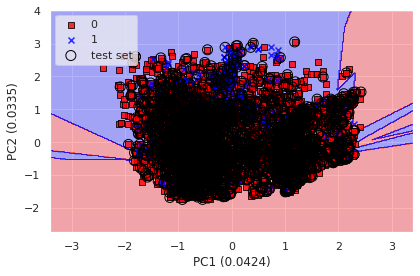

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
X_transformed = pca.fit_transform(X_combined)

test_idx = range(X_train.shape[0], X_combined.shape[0])
plot_decision_regions(X_transformed, y_combined, model, test_idx=test_idx, pca=pca)
plt.xlabel('PC1 ({:.4f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.4f})'.format(pca.explained_variance_ratio_[1]))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

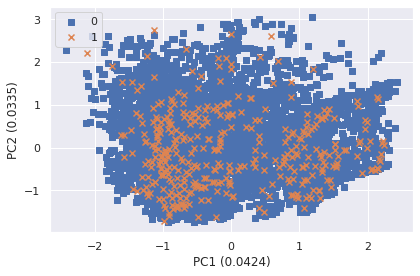

In [ ]:
markers = ('s', 'x')
for idx, cl in enumerate(np.unique(y)):
  plt.scatter(X_transformed[y==cl, 0], X_transformed[y==cl, 1], 
              marker=markers[idx], label=cl)

plt.xlabel('PC1 ({:.4f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.4f})'.format(pca.explained_variance_ratio_[1]))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   141  100   141    0     0    694      0 --:--:-- --:--:-- --:--:--   691
100 53850  100 53850    0     0  84536      0 --:--:-- --:--:-- --:--:-- 84536


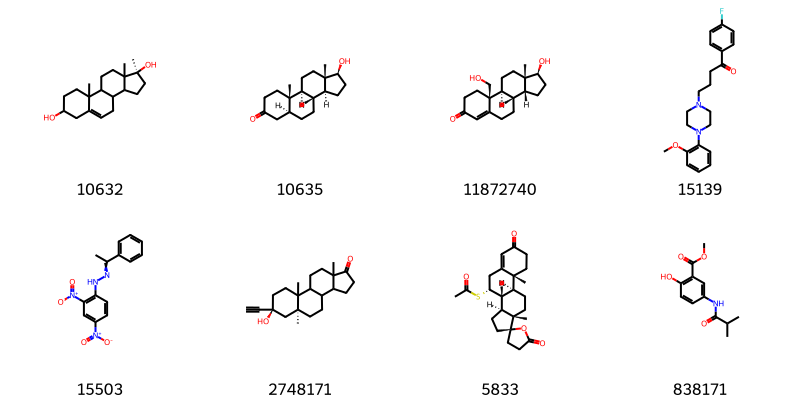

In [ ]:
!curl -Lo compound_list.sdf https://bit.ly/3WLUEtS

sup = Chem.SDMolSupplier('compound_list.sdf')
unknowns = [mol for mol in sup if mol is not None]
cids = [mol.GetProp('PUBCHEM_COMPOUND_CID') for mol in unknowns]
Draw.MolsToGridImage(unknowns, legends=cids, molsPerRow=4)

In [ ]:
X_unknowns = [ AllChem.GetMorganFingerprintAsBitVect(m, 2)
		for m in unknowns]
X_unknowns = [ np.asarray(x) for x in X_unknowns]
X_unknowns = np.vstack(X_unknowns)
y_unknowns_pred = model.predict(X_unknowns)
for cid, pred in zip(cids, y_unknowns_pred):
  print(cid, pred)

10632 0
10635 1
11872740 1
15139 0
15503 0
2748171 1
5833 1
838171 0
